In [20]:
%matplotlib inline
import time
import random
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os, sys
import time
plt.rcParams.update({'font.size': 14})

def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vdiff*np.exp(-I/A)+vmin

def tothecenter(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 2

def reflectrand(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    angleh += np.random.uniform(-45,45)
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 1, value
    
def calcintensity(laser,laserframe,delay):
    if delay >= 0:   #positive delay - past   - calc velocity due to sensed intensity[i-delay]
        if laserframe < delay: laser[laserframe,4] = vfactor*np.exp(-laser[0,3]/amplitude)+vmin   #if i < delay
        else: laser[laserframe,4] = vfactor*np.exp(-laser[laserframe-delay,3]/amplitude)+vmin
    else:            #negative delay - future
        if laserframe >= fitlength:    #extrapolate intensity value
            popt,pcov = curve_fit(linear, fitwave, laser[laserframe-fitlength:laserframe,3],p0 = (0,0))
            futurevalue = linear(-delay,*popt)
            vvalue = vfactor*math.exp(-futurevalue/amplitude)+vmin
            if vvalue >= 0 and vvalue <=1: laser[laserframe,4] = vvalue
            else:                     # 0 < intensity < 1
                if vvalue > 1: laser[laserframe,4] = 1
                if vvalue < 0: laser[laserframe,4] = 0 
        else:     # i < delay
            if laserframe < 2: laser[laserframe,4] = vfactor*math.exp(-laser[laserframe,3]/amplitude)+vmin
            else:
                popt,pcov = curve_fit(linear, fitwave[fitlength-laserframe:fitlength], laser[0:laserframe,3],p0 = (0,0))
                futurevalue = linear(-delay,*popt)
                if vvalue >= 0 and vvalue <= 1: laser[laserframe,4] = vvalue
                else:
                    if vvalue > 1: laser[laserframe,4] = 1
                    if vvalue < 0: laser[laserframe,4] = 0  
    return laser

def vectorlength(x): return np.sqrt(pow(x[0],2)+pow(x[1],2))

def calcvelocity(rrange,sigma,vdiff,A,vmin):         #Calculate the introduced velocity profile
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, maxvelomeasured*vdiff*np.exp(-I/A)+vmin, I

def normalize(inn):                                  #normalize the input curve to 1
    return inn/(sum(inn)*dx)

def calcvelocitysingle(rvalue,sigma,vdiff,A,vmin):   #Calculate the introduced velocity profile at a single position
    sigmaterm = sigma**2
    I = A*np.exp(-rvalue**2/sigmaterm)
    return vdiff*np.exp(-I/A)+vmin

def steplengththeory(t,v,taur):
    return v*t*(1-t/taur)

In [36]:
name = 'test'
np.random.seed(4) 
savefolder ='.'

dtin = 0.05                                       #iteration time of the camera [s]
stepsexp  = 500000                                    #number of camera pictures
reorientationtimeinput = 0.65
delay = 10                                      #Delay, negative value for anticipation
maxvelocity = 6e-6#5.25e-6                           #velocity of the particle depending on the laser power [m/s]
                                                #Fig 1c; https://www.nature.com/articles/s41467-018-06445-1.pdf
amplitude = 1
vmin = 0                                     #Min velocity
vmax = 1                                        #Max velocity
pxtomum=0.0533e-6                               #px to µm [µm/px]
sigma = 50*pxtomum                                     #Sigma for the Gaussian intensity profile [px]
D_0 = 3.85e-14                                  #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
kB = 1.38064852e-23                              #Boltzmanns constant [J/K]
T = 273.15 + 20                                  #Room temperature [K]
eta = 2.414e-5*10**(247.8/(T-140))               #Viscosity [Pa*s]
offset = 12                                     #offset of the laser [px]
boundaryradius = pxtomum * 200                  #Radius of the boundary [px]
diameter = 2.19e-6                              #diameter of the particle [m]
fitlength = 5                                   #for negative delay, linear fit on the last N measured intensities to extrapolate intensity
diffusion = True                                #Switching diffusion on and off
vprofilesteps = 200               #radial start points                               
stepstheo = 180                       #angular steps
boundaryparameter = 0.5          #parameter defining the strength of the influence of the boundary bounce
driftparameter =0.5#1             #parameter defining the strength of the drift
howmany = 20

dtin = 0.05
videosize = 800        #800, 521, 256, 128
binning = 1
frametransfer = False
flashtime = 0.01
verticalshift = 1.9176e-6
dtprogram = 2e-3
dtcamtoPC = 1e-3
dtPCtoADwin = 1e-3

dtframetransfer = videosize/binning * verticalshift
dtreadout = (1032/27e6+verticalshift)*videosize/binning
dt = dtin + dtframetransfer
dtexphalf = flashtime/2
dttotal = dtexphalf + dtframetransfer + dtreadout + dtcamtoPC + dtprogram + dtPCtoADwin
delaytime = dttotal + (delay-1)*dt
noise = np.sqrt(240/(reorientationtimeinput-dt))

In [39]:
numdelay = 10
delayarray1 = np.zeros(numdelay)
for i in range(numdelay):
    delayarray1[i] = 1 + 4*i
probarray = np.zeros((anglesteps,howmany,numdelay))    


calctime = 0
for q in range(numdelay):
    start_time = time.time() 
    delay = int(delayarray1[q])
    
    shortlength = stepsexp
    prefactor = np.sqrt(2*D_0*dt)                 #value for calculation of the random steps
    sumhitboundary = 0
    fitwave = np.linspace(-fitlength+1,1,fitlength,endpoint=False)
    sigmafactor = pow(sigma,2)
    vfactor=vmax-vmin
    radius = diameter/2

    shorttimewave = np.linspace(0,dt*stepsexp,stepsexp,endpoint=False)  #Timewave for sub cam resolution
    laser = np.zeros((shortlength+1,5))              #laserposition  0 - x; 1 - y; 2 - time at which the laser is set to the new position
                                                     #               3 - Ext Int it measures; 4 - theo speed(Int laser)
    particle = np.zeros((stepsexp,8))    #cam detection  0 - x; 1 - y; 2 - time of the average particle position
                                                     #               3 - time at which the the laser is placed 
                                                     #               4 - path number
                                                     #               5 - angle; 6 - out
                                                     #               7 - Distance to center        
    noisesteps = np.zeros((stepsexp,2)); anglenoise = np.zeros(stepsexp) 
    for i in range(2): noisesteps[:,i] = prefactor*np.random.normal(0,1,stepsexp) #Create random steps
    if noise != 0: anglenoise[:] = noise*np.random.normal(0,1,stepsexp)           #Create random angle noise
    deltas = np.zeros(2)
    particle[0,5] = np.random.uniform(0,360)
    particle[0,0] = np.random.uniform(0,0.7*boundaryradius)*np.cos(np.random.uniform(0,2*np.pi))
    particle[0,1] = np.random.uniform(0,0.7*boundaryradius)*np.sin(np.random.uniform(0,2*np.pi))
    #----------------------------------------------------------
    startpoint = [0]; endpoint = []; out = 0
    for i in range(1,stepsexp):
        particle[i,2] = particle[i-1,2] + dt                
        particle[i,:2] = particle[i-1,:2]                              #Position equals position before
        particle[i,5] = particle[i-1,5]
        particle[i,7] = np.sqrt(pow(particle[i,0],2) + pow(particle[i,1],2))   #distance to the center
        if particle[i,7] > boundaryradius:      #particle is out
            if particle[i,7] > 1.1 * boundaryradius: particletest[i,5], out = tothecenter(particle[i,0],particle[i,1],particle[i,5])  #sendback to the center if something really fails
            else:
                if out == 0:   #reflect randomly at the boundary
                    particle[i,5], out, incidentangle = reflectrand(particle[i,0],particle[i,1],particle[i,5])
                    endpoint.append(i)
        else:  
            if out != 0: startpoint.append(i)
            out = 0
        particle[i,6] = out
        if out == 0: particle[i,5] += anglenoise[i]   #add noise at the angle if it is inside
        if particle[i,5] > 360: particle[i,5] -= 360
        if particle[i,5] < 0: particle[i,5] += 360
        laser[i,0] = particle[i,0]+offset*pxtomum*np.cos(particle[i,5]*np.pi/180)   #laser position      
        laser[i,1] = particle[i,1]+offset*pxtomum*np.sin(particle[i,5]*np.pi/180)
        laser[i,3] = amplitude*math.exp(-pow(particle[i,7],2)/sigmafactor)        #intensity of the external field
        laser = calcintensity(laser,i,delay)     #calc laser intensity depending on the field intensity 
        if diffusion == True:
            for j in range(2): particle[i,j] += noisesteps[i,j]         #add diffusion of the particle
        for j in range(2): deltas[j] = particle[i,j]-laser[i,j]
        particle[i,3] = np.sqrt(pow(deltas[0],2)+pow(deltas[1],2))      #calc particle-laser distance
        particle[i,4] = maxvelocity
        for j in range(2): particle[i,j] += particle[i,4]/particle[i,3]*deltas[j]*dt*laser[i,4]  #add thermophoretic movement
        particle[i,7] = np.sqrt(pow(particle[i,0],2) + pow(particle[i,1],2))
    if particle[i,7] < boundaryradius: endpoint.append(i-1)   
    #----------------------------------------------------------
    teststeps = howmany
    vtest = np.zeros((teststeps,4))
    vdiffarray = np.zeros((teststeps,8))
    first = np.linspace(0,boundaryradius*1e6,teststeps+1)
    for i in range(teststeps): vtest[i,0] = (first[i]+first[i+1])/2

    distancetocenter = np.sqrt(pow(particle[:,0],2)+pow(particle[:,1],2))*1e6
    angle = particle[:shortlength,5]
    particlesdisplay = np.zeros((shortlength,2))
    particlesdisplay[:,0] = particle[:,0]*1e6
    particlesdisplay[:,1] = particle[:,1]*1e6
    directionvector = np.zeros((shortlength,2))
    movingvector = np.zeros((shortlength,2))
    velocity = np.zeros(shortlength);stepsize = np.zeros(shortlength)
    velocitywithdiffusion=np.zeros(shortlength)
    directionvector[:,0] = np.cos(angle[:]*np.pi/180)
    directionvector[:,1] = np.sin(angle[:]*np.pi/180)
    for i in range(1,shortlength-1):
        movingvector[i,0] = particlesdisplay[i,0]-particlesdisplay[i-1,0]
        movingvector[i,1] = particlesdisplay[i,1]-particlesdisplay[i-1,1]
        stepsize[i] = abs(np.dot(directionvector[i-1,:], movingvector[i,:]))
        velocity[i] = stepsize[i]/dt
    velocitywithdiffusion[:] = np.sqrt(pow(movingvector[:,0],2)+pow(movingvector[:,1],2))/dt 
    velocitywithdiffusion[0] = np.nan
    velocity[0] = np.nan

    for i in range(1,shortlength):
        j = 0; check = True
        while check == True:
            if distancetocenter[i] >= first[j] and distancetocenter[i] <= first[j+1]:
                vtest[j,1] += 1
                vtest[j,2] += velocity[i]
                diff = distancetocenter[i] -  distancetocenter[i-1] 
                if diff > 0:
                    vdiffarray[j,0] += 1
                    vdiffarray[j,2] += velocity[i]
                    vdiffarray[j,4] += diff/dt
                else:
                    vdiffarray[j,1] += 1
                    vdiffarray[j,3] += velocity[i]
                    vdiffarray[j,5] += abs(diff)/dt
                check = False
            else: j += 1
            if j == teststeps: check = False
    vtest[:,2] /= vtest[:,1]              #velocity
    vtest[:,3] = vtest[:,1]/vtest[:,0]    #density
    dxexp = vtest[1,0] - vtest[0,0]
    vtest[:,3] /= sum(vtest[:,3]*dxexp)

    vdiffarray[:,2] /= vdiffarray[:,0]
    vdiffarray[:,3] /= vdiffarray[:,1]
    vdiffarray[:,4] /= vdiffarray[:,0]
    vdiffarray[:,5] /= vdiffarray[:,1]
    vdiffarray[:,6] = vdiffarray[:,3] - vdiffarray[:,2]
    vdiffarray[:,7] = vdiffarray[:,5] - vdiffarray[:,4]

    maxvcount = 0; maxvelomeasured = 0
    for i in range(1,shortlength):
        if laser[i,4] == 1:
            maxvcount += 1
            maxvelomeasured += velocity[i]
    maxvelomeasured = np.nanmax(vtest[:,2]) #/= maxvcount
    #----------------------------------------------------------
    vdiff = vmax - vmin
    onestep = 360/stepstheo
    rwave = np.linspace(0,boundaryradius*1e6,vprofilesteps,endpoint=True)
    dx = rwave[1] - rwave[0]
    maxdelay = delay +1
    number = delay +1
    taur = reorientationtimeinput
    values = np.zeros(number); delayarray = np.zeros(number)
    for i in range(number):                  #calculate the delay for the different steps
        values[i] = 1 + i
        delayarray[i] = dttotal + (values[i]-1)*dt

    everystep = np.zeros((maxdelay,vprofilesteps,stepstheo,4))                    #every step on the path to the past position is saved
    importantsteps = np.zeros((number,vprofilesteps,stepstheo,4))                 #just the steps of the wanted delays are saved
    everystep[0,:,:,0] = 0
    for i in range(vprofilesteps): everystep[0,i,:,1] = rwave[i]              #radial startposition
    for i in range(stepstheo): everystep[:,:,i,2] = onestep*i                     #angular startposition
    for i in range(vprofilesteps):
        for j in range(stepstheo):
            count = 0
            for p in range(1,maxdelay+1):
                dist = np.sqrt(pow(everystep[p-1,i,j,0],2)+pow(everystep[p-1,i,j,1],2))    #dist to center for every position
                if dist >= boundaryradius*1e6:                                                 #boundary condition - reflexion of v-profile
                    dist = 2*boundaryradius*1e6 - boundaryparameter*dist                       #v-profile is mirrored at the boundary
                everystep[p-1,i,j,3] = maxvelomeasured*calcvelocitysingle(dist,sigma*1e6,vdiff,amplitude,vmin)  #calculate v for every position
                step = steplengththeory(dt,everystep[p-1,i,j,3],taur)                  #caclculate step length for every position
                if p < maxdelay:
                    everystep[p,i,j,0] = everystep[p-1,i,j,0] + np.cos(everystep[p-1,i,j,2]*np.pi/180)*step   #calculate new position
                    everystep[p,i,j,1] = everystep[p-1,i,j,1] + np.sin(everystep[p-1,i,j,2]*np.pi/180)*step
                if count < number:                                           #save just important steps
                    if p-1 == values[count]:
                        importantsteps[count,i,j,:4] = everystep[p-1,i,j,:4]
                        count += 1

    vprofiles = np.zeros((number,vprofilesteps,4))
    for i in range(number):
        for j in range(vprofilesteps):
            vprofiles[i,j,0] = np.mean(importantsteps[i,j,:,3])                        #calculate v profile
            vprofiles[i,j,1] = np.mean(importantsteps[i,j,int(vprofilesteps/2):,3])    #v moving outwards
            vprofiles[i,j,2] = np.mean(importantsteps[i,j,:int(vprofilesteps/2),3])    #v moving inwards
            vprofiles[i,j,3] = vprofiles[i,j,2] - vprofiles[i,j,1]                     #v difference

    savedensity2 = np.zeros((vprofilesteps,number))             #solve the ODe to get the density from the D- and v_diff profiles
    for k in range(number):
        Darray = np.zeros(vprofilesteps)
        Darray = D_0+vprofiles[k,:,0]**2*taur/4# + D_0
        c = np.zeros(vprofilesteps)                             #array to save the density distributions
        c[0] = 1
        for i in range(0,vprofilesteps-1):
            c[i+1] = c[i] * (1 - dx/Darray[i]*((Darray[i+1]-Darray[i])/(2*dx)+driftparameter*vprofiles[k,i,3]))
            c[:] = c[:]/sum(abs(c[:])*dx)                       #Normalize
        savedensity2[:,k] = c                                   #saveit

    maxpoints = np.zeros((number,2))
    for i in range(number):                                     #find and save maximum points of the drift for every delay
        maxpoints[i,1] = max(vprofiles[i,:,3])
        check = np.argmax(vprofiles[i,:,3])
        maxpoints[i,0] = rwave[check]
    #----------------------------------------------------------
    test = np.zeros((shortlength,5))
    for i in range(shortlength):
        test[i,0] = particle[i,7]*1e6                                   #radial position
        test[i,1] = math.atan2(particle[i,0],particle[i,1])*180/np.pi   #angular position
        test[i,2] = particle[i,0]*1e6                                   #x position
        test[i,3] = particle[i,1]*1e6                                   #y position
    for i in range(shortlength):
        diff = np.zeros(3)                                              #correct jumps from 360 to 0 for angular
        diff[0] = abs(test[i,1] - test[i-1,1])
        diff[1] = abs(test[i,1] - test[i-1,1] + 180)
        diff[2] = abs(test[i,1] - test[i-1,1] - 180)
        if np.argmin(diff) == 1: test[i:,1] += 360
        if np.argmin(diff) == 2: test[i:,1] -= 360

    first = np.linspace(0,boundaryradius*1e6,howmany+1)
    checkdistarray = np.zeros(howmany)
    for i in range(howmany): checkdistarray[i] = (first[i] + first[i+1])/2  #check ring at these radial positions

    savecheckcount = np.zeros(howmany)
    checkdx = 0.05                                                      #interval for check is -dx ... +dx

    anglesteps = 36
    firstarray = np.linspace(-180,180,anglesteps+1)
    anglearray = np.zeros(anglesteps)
    for i in range(anglesteps): anglearray[i] = (firstarray[i]+firstarray[i+1])/2  #angular steps

    checkposition = np.zeros((shortlength,howmany,6))
    collectdata = np.zeros((anglesteps,howmany,6))
    for m in range(howmany):
        checkdist = checkdistarray[m]
        checkcount = 0
        for i in range(delay,shortlength):
            if test[i,0] >= checkdist-checkdx and test[i,0] < checkdist+checkdx:     
                checkposition[checkcount,m,0] = test[i-delay,0]                 #past radial position
                checkposition[checkcount,m,1] = test[i,1] - test[i-delay,1]     #past angular position projected on x-axis
                checkposition[checkcount,m,2] = checkposition[checkcount,m,0]*np.cos(checkposition[checkcount,m,1]*np.pi/180) - test[i,0] #past x-position centered around (0,0)
                checkposition[checkcount,m,3] = checkposition[checkcount,m,0]*np.sin(checkposition[checkcount,m,1]*np.pi/180)             #past y-position centered around (0,0)
                checkposition[checkcount,m,4] = np.sqrt(pow(checkposition[checkcount,m,2],2)+pow(checkposition[checkcount,m,3],2))        #past radial position in reference to actual position    
                checkposition[checkcount,m,5] = math.atan2(checkposition[checkcount,m,3],checkposition[checkcount,m,2])*180/np.pi         #past angular position in reference to actual position
                checkcount += 1   
        finalposition = np.zeros((checkcount,4))
        finalposition = checkposition[:checkcount,m,:]
        finalposition[:,2] += checkdist
        savecheckcount[m] = checkcount

        for i in range(checkcount):
            check = True; j = 0
            while check == True:  
                anglestart = -180 + j*360/anglesteps
                angleend = -180 + (j+1)*360/anglesteps       
                if finalposition[i,5] >= anglestart and finalposition[i,5] <= angleend:  #do statistics in reference frame of actual position
                    collectdata[j,m,0] += 1
                    collectdata[j,m,1] += finalposition[i,4]
                    check = False
                j += 1
        collectdata[:,m,1] /= collectdata[:,m,0]
        collectdata[:,m,2] = collectdata[:,m,1]*np.cos(anglearray*np.pi/180) + checkdist   #past x-position projected on x-axis in reference frame of (0,0) 
        collectdata[:,m,3] = collectdata[:,m,1]*np.sin(anglearray*np.pi/180)               #past y-position projected on x-axis in reference frame of (0,0)
        collectdata[:,m,4] = np.sqrt(pow(collectdata[:,m,2],2)+pow(collectdata[:,m,3],2))  #past radial position in frame of (0,0)
        for i in range(anglesteps): collectdata[i,m,5] = math.atan2(collectdata[i,m,3],collectdata[i,m,2])*180/np.pi #past angular position in frame of (0,0)

    simvelo = np.zeros((howmany,6))
    for i in range(howmany):
        for j in range(int(savecheckcount[i])):
            v = maxvelomeasured*calcvelocitysingle(checkposition[j,i,0],sigma*1e6,vdiff,amplitude,vmin)
            simvelo[i,0] += v
            simvelo[i,3] += 1
            if abs(checkposition[j,i,5]) > 90:
                simvelo[i,1] += v
                simvelo[i,4] += 1
            else:
                simvelo[i,2] += v
                simvelo[i,5] += 1
    simvelo[:,0] /= simvelo[:,3]
    simvelo[:,1] /= simvelo[:,4]
    simvelo[:,2] /= simvelo[:,5]

    savedensity3 = np.zeros((howmany,1))             #solve the ODe to get the density from the D- and v_diff profiles
    dx2 = checkdistarray[1] - checkdistarray[0]
    for k in range(1):
        Darray = np.zeros(howmany)
        Darray = D_0+simvelo[:,0]**2*taur/4# + D_0
        c = np.zeros(howmany)                             #array to save the density distributions
        c[0] = 1
        for i in range(0,howmany-1):
            c[i+1] = c[i] * (1 - dx2/Darray[i]*((Darray[i+1]-Darray[i])/(2*dx2)+driftparameter*(simvelo[i,2]-simvelo[i,1])))
            c[:] = c[:]/sum(abs(c[:])*dx2)                       #Normalize
        savedensity3[:,k] = c                                   #saveit
    string_temp = savefolder + '/PlotOverview-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotOverview-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    
    colorwave = cm.plasma(np.linspace(0, 1, number))
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(r'$\tau_{r} = $'+str(taur)+' s - $v_{max} = $'+str(maxvelocity*1e6)+' µm/s - delay = '+str(delay)+' - boundary factor = '+str(boundaryparameter)+' - drift factor = '+str(driftparameter), fontsize=16)

    ax1 = plt.subplot(2,3,1)
    ax1.plot(rwave,vprofiles[-2,:,0],color='b',label = 'Theory')
    ax1.plot(checkdistarray,simvelo[:,0],color='g',label = 'Sim - created')
    ax1.plot(vtest[:,0],vtest[:,2],color='k',label = 'Sim - measured') #actual seen in simulation
    ax1.set_xlabel('Distance to center [µm]')
    ax1.set_ylabel('Velocity [µm/s]') 
    ax1.set_title('Velocity profiles')
    ax1.set_xlim(0,boundaryradius*1e6)
    ax1.legend()

    ax2 = plt.subplot(2,3,2)
    ax2.plot(vtest[:-1,0],vdiffarray[:-1,6],color='k',label = r'Sim - $v_{active}$')
    ax2.plot(vtest[:-1,0],vdiffarray[:-1,7],color='k',label = r'Sim - $v_{radial}$',linestyle='--')
    ax2.plot(rwave,vprofiles[-2,:,2]-vprofiles[-2,:,1],color='b',label='Theory')
    ax2.plot(checkdistarray,simvelo[:,2]-simvelo[:,1],color='g',label='Sim - created')
    ax2.set_xlabel('Distance to center [µm]')
    ax2.set_ylabel('Drift velocity [µm/s]') 
    ax2.set_title('Drift velocity')
    ax2.set_xlim(0,boundaryradius*1e6)
    ax2.axhline(y=0,linewidth=0.5, color = 'grey',linestyle='--')
    ax2.legend()

    ax3 = plt.subplot(2,3,3)
    ax3.plot(rwave,savedensity2[:,delay-1],c='b',label='Theory')
    ax3.plot(checkdistarray,savedensity3[:,0],c='g',label='Sim - ODE')
    ax3.plot(vtest[:,0],vtest[:,3],color='k',label='Sim - measured')
    ax3.set_xlabel('Distance to center [µm]')
    ax3.set_ylabel('Normalized density') 
    ax3.set_title('Density')
    ax3.set_xlim(0,boundaryradius*1e6)
    ax3.legend()

    colorwave = cm.plasma(np.linspace(0, 1, howmany))
    ax4 = plt.subplot(2,1,2)
    ax4.set_aspect('equal')
    check = True
    for i in range(howmany):
        if (i-1) % 4 == 0 :
            end = int(savecheckcount[i])
            ax4.scatter(checkposition[:end,i,2],checkposition[:end,i,3],alpha=0.05,color=colorwave[i])
            if check == True:
                ax4.plot(collectdata[:,i,2],collectdata[:,i,3],color='k',linestyle='--',label='Simulation')
                check = False
            else: ax4.plot(collectdata[:,i,2],collectdata[:,i,3],color='k',linestyle='--')
            ax4.plot([collectdata[0,i,2],collectdata[-1,i,2]],[collectdata[0,i,3],collectdata[-1,i,3]],color='k',linestyle='--')
            ax4.plot([checkdistarray[i]-checkdx,checkdistarray[i]+checkdx],[0,0],color=colorwave[i],linewidth=5)

    circle2 = plt.Circle((0, 0), boundaryradius*1e6, color='k',linestyle='--', fill=False)
    ax4.add_artist(circle2)
    ax4.scatter([0],[0],color='k',marker='x')
    ax4.set_xlabel('x [µm]')
    ax4.set_ylabel('y [µm]')
    ax4.set_title('Travel circles')
    check = True
    for i in range(howmany):
        if (i-1) % 4 == 0:
            value = np.argmin(abs(rwave-checkdistarray[i]))
            if check == True:
                ax4.plot(importantsteps[delay-1,value,:,1],importantsteps[delay-1,value,:,0],c='k',label='Theory')
                check = False
            else: ax4.plot(importantsteps[delay-1,value,:,1],importantsteps[delay-1,value,:,0],c='k')
            ax4.plot([importantsteps[delay-1,value,-1,1],importantsteps[delay-1,value,0,1]],[importantsteps[delay-1,value,-1,0],importantsteps[delay-1,value,0,0]],c='k',linewidth = 2)
            ax4.scatter(rwave[value],0,s=80,color='k')
    ax4.legend()
    axes = [ax1, ax2, ax3, ax4]

    plt.tight_layout() 
    plt.savefig(string_temp+'Overview - boundary = '+str(boundaryparameter)+' - drift = '+str(driftparameter)+' - delay = '+str(delay)+'.pdf', format='pdf')
    plt.savefig(string_temp2+'Overview - boundary = '+str(boundaryparameter)+' - drift = '+str(driftparameter)+' - delay = '+str(delay)+'.svg', format='svg')
    plt.close(fig)#show()  
    #----------------------------------------------------------
    string_temp = savefolder + '/PlotCircle-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotCircle-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    colorwave = cm.plasma(np.linspace(0, 1, howmany))
    fig = plt.figure(figsize=(10, 8))
    ax4 = plt.subplot(1,1,1)
    ax4.set_aspect('equal')
    check = True
    for i in range(howmany):
        if (i-1) % 4 == 0 :
            end = int(savecheckcount[i])
            ax4.scatter(checkposition[:end,i,2],checkposition[:end,i,3],alpha=0.05,color=colorwave[i])
            if check == True:
                ax4.plot(collectdata[:,i,2],collectdata[:,i,3],color='k',linestyle='--',label='Simulation')
                check = False
            else: ax4.plot(collectdata[:,i,2],collectdata[:,i,3],color='k',linestyle='--')
            ax4.plot([collectdata[0,i,2],collectdata[-1,i,2]],[collectdata[0,i,3],collectdata[-1,i,3]],color='k',linestyle='--')
            ax4.plot([checkdistarray[i]-checkdx,checkdistarray[i]+checkdx],[0,0],color=colorwave[i],linewidth=5)

    circle2 = plt.Circle((0, 0), boundaryradius*1e6, color='k',linestyle='--', fill=False)
    ax4.add_artist(circle2)
    ax4.scatter([0],[0],color='k',marker='x')
    ax4.set_xlabel('x [µm]')
    ax4.set_ylabel('y [µm]')
    ax4.set_title('Travel circles')
    check = True
    for i in range(howmany):
        if (i-1) % 4 == 0:
            value = np.argmin(abs(rwave-checkdistarray[i]))
            if check == True:
                ax4.plot(importantsteps[delay-1,value,:,1],importantsteps[delay-1,value,:,0],c='k',label='Theory')
                check = False
            else: ax4.plot(importantsteps[delay-1,value,:,1],importantsteps[delay-1,value,:,0],c='k')
            ax4.plot([importantsteps[delay-1,value,-1,1],importantsteps[delay-1,value,0,1]],[importantsteps[delay-1,value,-1,0],importantsteps[delay-1,value,0,0]],c='k',linewidth = 2)
            ax4.scatter(rwave[value],0,s=80,color='k')
    ax4.legend()

    plt.tight_layout() 
    plt.savefig(string_temp+'Circles - boundary = '+str(boundaryparameter)+' - drift = '+str(driftparameter)+' - delay = '+str(delay)+'pdf', format='pdf')
    plt.savefig(string_temp2+'Circles - boundary = '+str(boundaryparameter)+' - drift = '+str(driftparameter)+' - delay = '+str(delay)+'.svg', format='svg')
    plt.close(fig)#show()  
    
    string_temp = savefolder + '/PlotProb-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotProb-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    fig, ax = plt.subplots(figsize=(7,5)) 
    ax4 = plt.subplot(1,1,1)
    for i in range(howmany): 
        if i % 2 == 0:
            #plt.plot(anglearray,collectdata[:,i,1],color=colorwave[i])
            plt.plot(anglearray,collectdata[:,i,0],color=colorwave[i])
    plt.ylim([0,1.1*np.amax(collectdata[:,:-2,0])])
    ax4.set_xlabel(r'Angle [$^{\circ}$]')
    ax4.set_ylabel('Counts')
    plt.tight_layout() 
    data = np.linspace(checkdistarray[0], checkdistarray[-1], howmany).reshape(howmany, 1)
    im = ax.imshow(data, cmap='plasma')
    divider = make_axes_locatable(ax4)
    cax = fig.add_axes([0.78, 0.5, 0.03, 0.4])
    plt.colorbar(im, cax=cax)
    plt.text(0.8,11,r'$r \: [\rm{\mu m}]$')

    plt.savefig(string_temp+'Probability - boundary = '+str(boundaryparameter)+' - drift = '+str(driftparameter)+' - delay = '+str(delay)+'.pdf', format='pdf')
    plt.savefig(string_temp2+'Probability - boundary = '+str(boundaryparameter)+' - drift = '+str(driftparameter)+' - delay = '+str(delay)+'.svg', format='svg')
    plt.close(fig)#show()  
    
    probarray[:,:,q] = collectdata[:,:,0]
    
    print('delay = '+str(delay))
    print("--- %s seconds ---" % round((time.time() - start_time),2))
    calctime += round((time.time() - start_time),2)
print('Total duration: ',calctime,' s')

delay = 1
--- 60.7 seconds ---


<ipython-input-39-f80ad1d3b95d>:246: RuntimeWarning: invalid value encountered in true_divide
  collectdata[:,m,1] /= collectdata[:,m,0]


delay = 5
--- 69.65 seconds ---


<ipython-input-39-f80ad1d3b95d>:246: RuntimeWarning: invalid value encountered in true_divide
  collectdata[:,m,1] /= collectdata[:,m,0]


delay = 9
--- 72.67 seconds ---


<ipython-input-39-f80ad1d3b95d>:246: RuntimeWarning: invalid value encountered in true_divide
  collectdata[:,m,1] /= collectdata[:,m,0]


delay = 13
--- 75.93 seconds ---


<ipython-input-39-f80ad1d3b95d>:246: RuntimeWarning: invalid value encountered in true_divide
  collectdata[:,m,1] /= collectdata[:,m,0]


delay = 17
--- 79.9 seconds ---


<ipython-input-39-f80ad1d3b95d>:246: RuntimeWarning: invalid value encountered in true_divide
  collectdata[:,m,1] /= collectdata[:,m,0]


delay = 21
--- 83.32 seconds ---


<ipython-input-39-f80ad1d3b95d>:246: RuntimeWarning: invalid value encountered in true_divide
  collectdata[:,m,1] /= collectdata[:,m,0]


delay = 25
--- 89.6 seconds ---


<ipython-input-39-f80ad1d3b95d>:246: RuntimeWarning: invalid value encountered in true_divide
  collectdata[:,m,1] /= collectdata[:,m,0]


delay = 29
--- 90.04 seconds ---


<ipython-input-39-f80ad1d3b95d>:246: RuntimeWarning: invalid value encountered in true_divide
  collectdata[:,m,1] /= collectdata[:,m,0]


delay = 33
--- 93.8 seconds ---


<ipython-input-39-f80ad1d3b95d>:246: RuntimeWarning: invalid value encountered in true_divide
  collectdata[:,m,1] /= collectdata[:,m,0]


delay = 37
--- 97.05 seconds ---
Total duration:  812.6599999999999  s


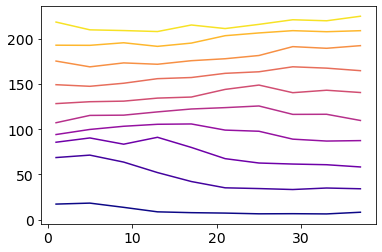

In [50]:
#anglesteps,howmany,numdelay

colorwave = cm.plasma(np.linspace(0, 1, howmany))
for j in range(howmany):
    if j % 2 == 0:
        test = np.zeros(numdelay)
        for k in range(numdelay):
            test[k] = np.mean(probarray[:,j,k])
        plt.plot(delayarray1,test,color=colorwave[j])

In [43]:
delayarray1

array([ 1.,  5.,  9., 13., 17., 21., 25., 29., 33., 37.])